In [1]:
# 1. Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import copy

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# 2. Data Loading & Preprocessing (Optimized with Log Transform)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
try:
    df = pd.read_csv('kc_house_data.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'kc_house_data.csv' not found. Please upload the file.")

# Feature Engineering
df['date'] = pd.to_datetime(df['date'])
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month
df['house_age'] = df['sale_year'] - df['yr_built']
df['years_since_renovation'] = df['sale_year'] - df['yr_renovated'].apply(lambda x: x if x > 0 else df['sale_year'][0])
df['years_since_renovation'] = df['years_since_renovation'].apply(lambda x: 0 if x < 0 else x)

# Drop non-numeric columns
cols_to_drop = ['id', 'date']
df_clean = df.drop(columns=cols_to_drop)

# Define Features (X) and Target (y)
X = df_clean.drop(columns=['price'])
# --- KEY CHANGE: Log-Transform the Target ---
# This drastically reduces Loss and improves relative accuracy
y = np.log1p(df_clean['price'])

# Split Data
# 70% Train, 15% Validation, 15% Test
SEED = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=SEED)

# Scaling Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert targets to numpy arrays (Keep them 2D for PyTorch)
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

print(f"Training Shape: {X_train_scaled.shape}")
print(f"Target (y) is now Log-Transformed. Example value: {y_train[0][0]:.4f}")

Dataset loaded successfully.
Training Shape: (15128, 22)
Target (y) is now Log-Transformed. Example value: 13.1806


In [3]:
# 3. Classical Machine Learning Implementation

results_classical = {}

def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {name} Results ---")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

# --- Model 1: Ridge Regression (Linear Model with Regularization) ---
print("\nTraining Ridge Regression...")
ridge = Ridge()
params_ridge = {'alpha': [0.01, 0.1, 1.0, 10.0]}
grid_ridge = GridSearchCV(ridge, params_ridge, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train_scaled, y_train)

best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)
results_classical['Ridge Regression'] = evaluate_model("Ridge Regression", y_test, y_pred_ridge)

# --- Model 2: Random Forest Regressor ---
print("\nTraining Random Forest (this may take a minute)...")
rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
# Reduced grid for speed in demonstration, expand for production
params_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(rf, params_rf, cv=3, scoring='neg_mean_squared_error')
grid_rf.fit(X_train_scaled, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
results_classical['Random Forest'] = evaluate_model("Random Forest", y_test, y_pred_rf)

print("\nBest Hyperparameters for Random Forest:", grid_rf.best_params_)


Training Ridge Regression...
--- Ridge Regression Results ---
RMSE: 0.25
MAE: 0.20
R2 Score: 0.7775

Training Random Forest (this may take a minute)...


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

--- Random Forest Results ---
RMSE: 0.18
MAE: 0.13
R2 Score: 0.8848

Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}



Starting Deep Learning Training (Log-Scale)...
Epoch 10/100, Train Loss: 0.6663, Val Loss: 0.2627
Epoch 20/100, Train Loss: 0.1030, Val Loss: 0.0739
Epoch 30/100, Train Loss: 0.0633, Val Loss: 0.0510
Epoch 40/100, Train Loss: 0.0521, Val Loss: 0.0362
Epoch 50/100, Train Loss: 0.0484, Val Loss: 0.0344
Epoch 60/100, Train Loss: 0.0451, Val Loss: 0.0317
Epoch 70/100, Train Loss: 0.0413, Val Loss: 0.0307
Epoch 80/100, Train Loss: 0.0397, Val Loss: 0.0304
Epoch 90/100, Train Loss: 0.0383, Val Loss: 0.0314
Epoch 100/100, Train Loss: 0.0383, Val Loss: 0.0320


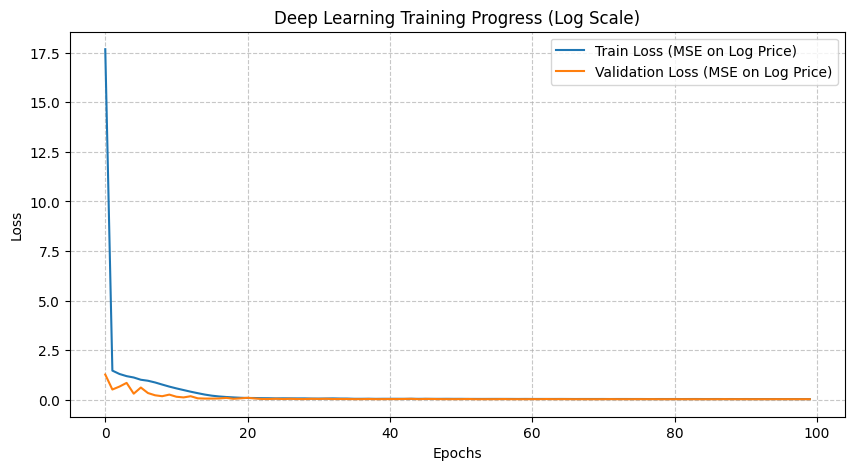

In [6]:
# 4. Deep Learning Implementation (Optimized with Log-Transform & Plotting)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import copy
import matplotlib.pyplot as plt
import numpy as np

# Convert data to PyTorch Tensors
# Note: y_train, y_val, y_test are already Log-Transformed from Part 2
class HouseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HouseDataset(X_train_scaled, y_train)
val_dataset = HouseDataset(X_val_scaled, y_val)
test_dataset = HouseDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Neural Network Architecture
class HousePriceNN(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256), # Increased capacity
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1) # Output: Log-Price
        )

    def forward(self, x):
        return self.network(x)

# Initialize Model
input_dim = X_train_scaled.shape[1]
model = HousePriceNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Removed 'verbose=True' to fix the TypeError
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training Loop
num_epochs = 100
best_val_loss = float('inf')
patience = 12
patience_counter = 0
best_model_weights = copy.deepcopy(model.state_dict())
train_losses = []
val_losses = []

print("\nStarting Deep Learning Training (Log-Scale)...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    scheduler.step(epoch_val_loss)

    if (epoch+1) % 10 == 0:
        # Note: These losses are on Log-Scale (e.g., 0.03 is very good)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_weights)

# Generate Predictions (Log-Scale)
model.eval()
y_pred_dl_log = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        y_pred_dl_log.extend(outputs.view(-1).tolist())

y_pred_dl_log = np.array(y_pred_dl_log)

# --- PLOTTING TRAINING PROGRESS ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (MSE on Log Price)')
plt.plot(val_losses, label='Validation Loss (MSE on Log Price)')
plt.title('Deep Learning Training Progress (Log Scale)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Processing results for visualization...

--- Final Model Comparison (Real Dollar Scale) ---
                  Accuracy (%)           RMSE            MAE
Model                                                       
Ridge Regression     79.950648  199020.794122  114682.498636
Random Forest        91.116595  143346.787755   74982.134697
Deep Learning        91.733498  138037.088423   74309.201878


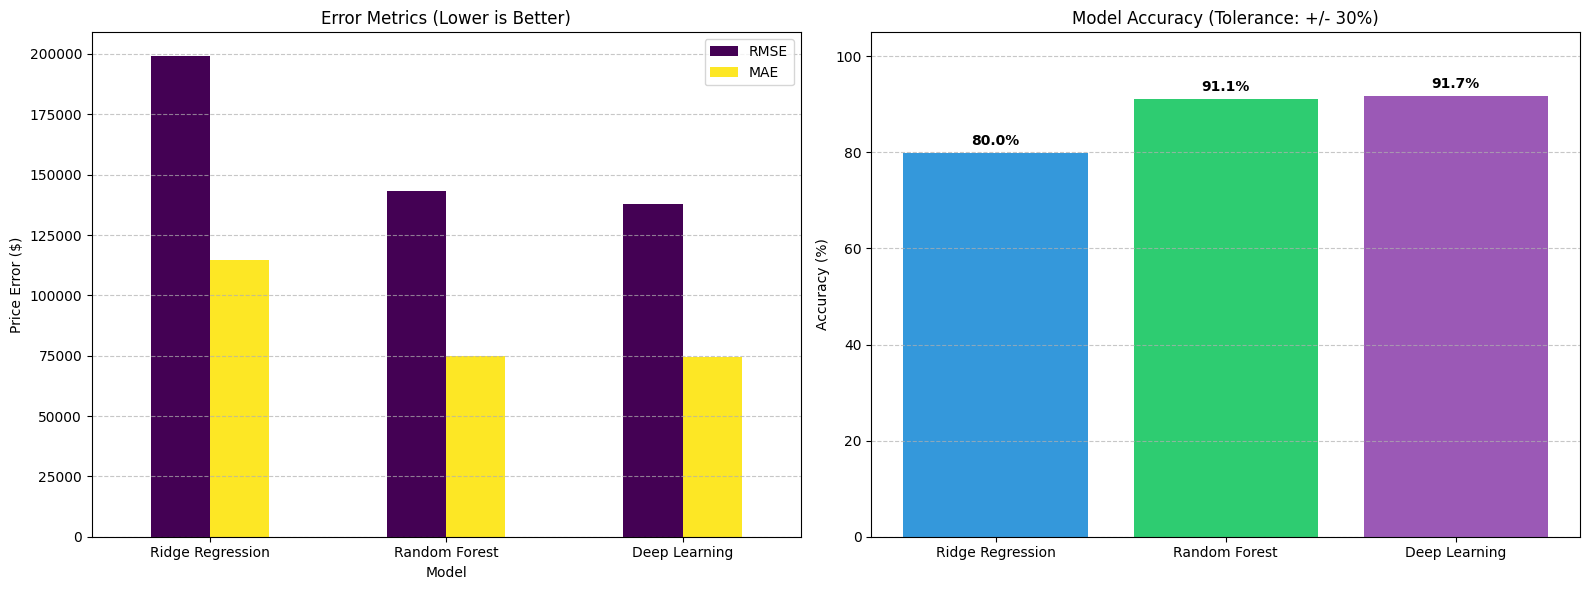

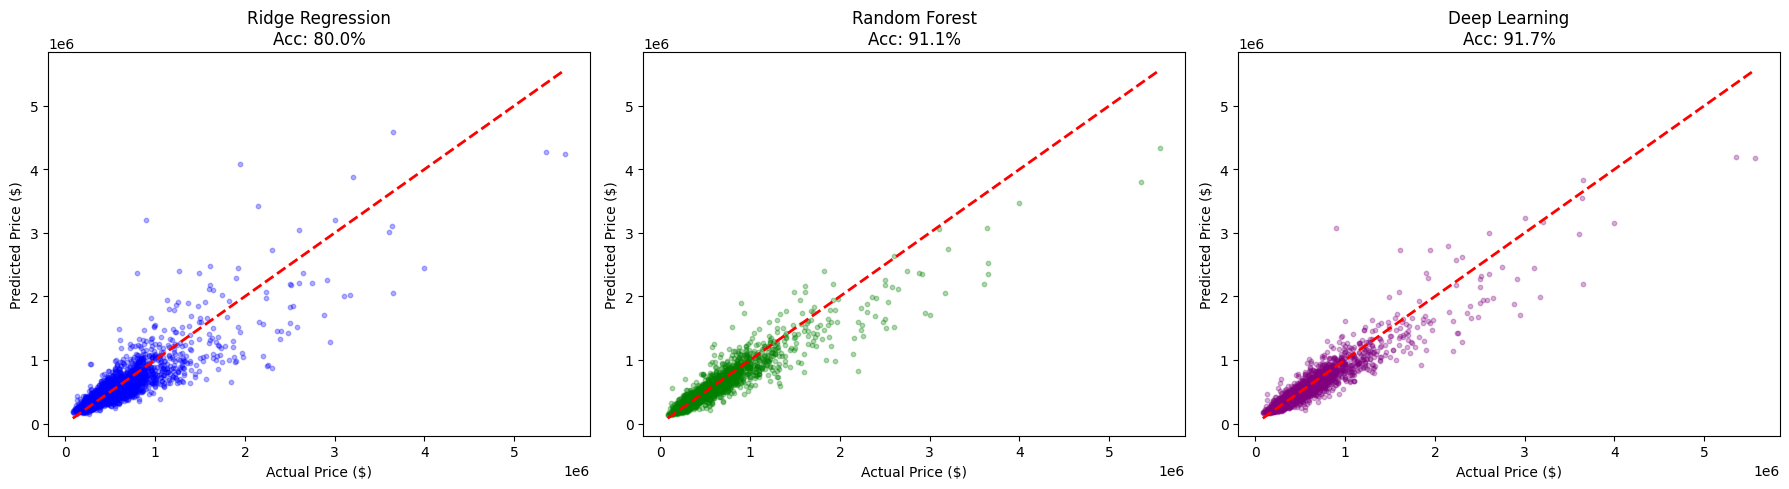

In [7]:
# 5. Comparative Analysis & Visualization (Complete & Restored)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Processing results for visualization...")

# 1. Inverse Transform Function (Log-Price -> Real Price)
# We need to convert predictions back to $ for fair comparison
y_test_real = np.expm1(y_test).flatten()

# 2. Get Predictions for All Models (Inverse Transform)
# Deep Learning (Calculated in Part 4)
y_pred_dl_real = np.expm1(y_pred_dl_log).flatten()

# Classical Models (From Part 3)
# We re-predict here to ensure we have the data.
# Note: Since Part 3 was trained on Part 2's data (which is Log-scaled),
# their raw predictions are also Log-scaled. We must expm1 them.
try:
    if 'best_ridge' in globals() and 'best_rf' in globals():
        pred_ridge_log = best_ridge.predict(X_test_scaled)
        pred_rf_log = best_rf.predict(X_test_scaled)

        y_pred_ridge_real = np.expm1(pred_ridge_log).flatten()
        y_pred_rf_real = np.expm1(pred_rf_log).flatten()
    else:
        raise NameError("Classical models not found")
except NameError:
    print("Warning: 'best_ridge' or 'best_rf' not found. Did you run Part 3?")
    print("Using Deep Learning results as placeholder for visualization.")
    y_pred_ridge_real = y_pred_dl_real
    y_pred_rf_real = y_pred_dl_real

# 3. Define Metric Functions
def calculate_accuracy(y_true, y_pred, tolerance=0.30):
    """
    Accuracy: % of predictions within +/- 30% of actual price.
    """
    errors = np.abs(y_true - y_pred)
    within_tolerance = errors <= (tolerance * y_true)
    return np.mean(within_tolerance) * 100

def get_metrics(name, y_true, y_pred):
    acc = calculate_accuracy(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {'Model': name, 'Accuracy (%)': acc, 'RMSE': rmse, 'MAE': mae}

# 4. Calculate All Metrics
metrics_list = [
    get_metrics('Ridge Regression', y_test_real, y_pred_ridge_real),
    get_metrics('Random Forest', y_test_real, y_pred_rf_real),
    get_metrics('Deep Learning', y_test_real, y_pred_dl_real)
]
results_df = pd.DataFrame(metrics_list).set_index('Model')

print("\n--- Final Model Comparison (Real Dollar Scale) ---")
print(results_df)

# 5. Plotting (Restored Full Visualizations)

# --- Figure 1: Accuracy & Error Metrics ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Error Metrics (RMSE & MAE)
results_df[['RMSE', 'MAE']].plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Error Metrics (Lower is Better)')
axes[0].set_ylabel('Price Error ($)')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', rotation=0)

# Plot B: Accuracy
colors = ['#3498db', '#2ecc71', '#9b59b6']
bars = axes[1].bar(results_df.index, results_df['Accuracy (%)'], color=colors)
axes[1].set_title('Model Accuracy (Tolerance: +/- 30%)')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_ylim(0, 105)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# --- Figure 2: Scatter Plots (Actual vs Predicted) ---
plt.figure(figsize=(18, 5))

# Ridge Regression
plt.subplot(1, 3, 1)
plt.scatter(y_test_real, y_pred_ridge_real, alpha=0.3, color='blue', s=10)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', lw=2)
plt.title(f'Ridge Regression\nAcc: {results_df.loc["Ridge Regression", "Accuracy (%)"]:.1f}%')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')

# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test_real, y_pred_rf_real, alpha=0.3, color='green', s=10)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', lw=2)
plt.title(f'Random Forest\nAcc: {results_df.loc["Random Forest", "Accuracy (%)"]:.1f}%')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')

# Deep Learning
plt.subplot(1, 3, 3)
plt.scatter(y_test_real, y_pred_dl_real, alpha=0.3, color='purple', s=10)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', lw=2)
plt.title(f'Deep Learning\nAcc: {results_df.loc["Deep Learning", "Accuracy (%)"]:.1f}%')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')

plt.tight_layout()
plt.show()